<a href="https://colab.research.google.com/github/eghib22/Store-Sales-Forecasting/blob/main/model_experiment_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! pip install dagshub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ekaterineghibradze","key":"b1414052fbae86987efff2083c8dcbd1"}'}

In [ ]:
!mv "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls -l ~/.kaggle/

total 4
-rw------- 1 root root 74 Jul  7 23:10 kaggle.json


In [ ]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
replace features.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv.zip        
replace sampleSubmission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: yyyy
  inflating: sampleSubmission.csv.zip  
replace stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: stores.csv              
replace test.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv.zip            
replace train.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv.zip           


In [ ]:
!unzip '*.csv.zip'

Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv            

Archive:  sampleSubmission.csv.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv    

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                

4 archives were successfully processed.


In [ ]:
!unzip '*.csv.zip'

Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv            

Archive:  sampleSubmission.csv.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv    

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                

4 archives were successfully processed.


In [ ]:
import dagshub
dagshub.init(repo_owner='eghib22', repo_name='Store-Sales-Forecasting', mlflow=True)

Accessing as eghib22

Initialized MLflow to track repo "eghib22/Store-Sales-Forecasting"

Repository eghib22/Store-Sales-Forecasting initialized!

In [ ]:
import pandas as pd

# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

# Explore the data
print("Train shape:", train.shape)
print(train.head())
print(train.columns)

print("\nTest shape:", test.shape)
print(test.head())
print(test.columns)

print("\nFeatures shape:", features.shape)
print(features.head())
print(features.columns)

print("\nStores shape:", stores.shape)
print(stores.head())
print(stores.columns)

print("\nSample Submission shape:", sample_submission.shape)
print(sample_submission.head())
print(sample_submission.columns)

Train shape: (421570, 5)
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

Test shape: (115064, 4)
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')

Features shape: (8190, 12)
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        3

In [ ]:
# Merge train and test with features and stores
train_merged = pd.merge(train, features, on=['Store', 'Date'], how='left')
train_merged = pd.merge(train_merged, stores, on='Store', how='left')

test_merged = pd.merge(test, features, on=['Store', 'Date'], how='left')
test_merged = pd.merge(test_merged, stores, on='Store', how='left')

# Convert Date to datetime
train_merged['Date'] = pd.to_datetime(train_merged['Date'])


In [ ]:
# Split
train_data = train_merged[train_merged['Date'] < '2012-01-01']
val_data = train_merged[(train_merged['Date'] >= '2012-01-01') & (train_merged['Date'] < '2012-07-01')]
test_data = train_merged[train_merged['Date'] >= '2012-07-01']

print("Train:", train_data.shape)
print("Validation:", val_data.shape)
print("Test (local):", test_data.shape)

Train: (294132, 17)
Validation: (77110, 17)
Test (local): (50328, 17)


<class 'pandas.core.frame.DataFrame'>
Index: 294132 entries, 0 to 421526
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         294132 non-null  int64         
 1   Dept          294132 non-null  int64         
 2   Date          294132 non-null  datetime64[ns]
 3   Weekly_Sales  294132 non-null  float64       
 4   IsHoliday_x   294132 non-null  bool          
 5   Temperature   294132 non-null  float64       
 6   Fuel_Price    294132 non-null  float64       
 7   MarkDown1     23700 non-null   float64       
 8   MarkDown2     20154 non-null   float64       
 9   MarkDown3     23116 non-null   float64       
 10  MarkDown4     21042 non-null   float64       
 11  MarkDown5     23994 non-null   float64       
 12  CPI           294132 non-null  float64       
 13  Unemployment  294132 non-null  float64       
 14  IsHoliday_y   294132 non-null  bool          
 15  Type          294132 n

<Axes: >

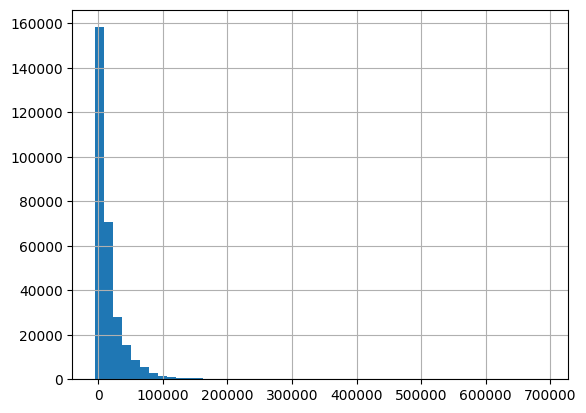

In [ ]:
print(train_data.info())
print(train_data.describe())
print(train_data.isnull().sum())
train_data['Weekly_Sales'].hist(bins=50)

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import FunctionTransformer
import joblib
import mlflow

# --- Preprocessing ---
def enhanced_preprocess(df):
    df = df.copy()
    type_map = {'A': 0, 'B': 1, 'C': 2}
    df['Type'] = df['Type'].map(type_map)

    if 'IsHoliday_x' in df.columns:
        df['IsHoliday'] = df['IsHoliday_x'].astype(int)
        df = df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])
    elif 'IsHoliday' in df.columns:
        df['IsHoliday'] = df['IsHoliday'].astype(int)

    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in markdown_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
    df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
    df['IsWeekend'] = df['Date'].dt.dayofweek.isin([5, 6]).astype(int)
    df['Quarter'] = df['Date'].dt.quarter

    return df.drop(columns=['Date'])

# --- Train/Val data ---
X_train = enhanced_preprocess(train_data.drop(columns=['Weekly_Sales']))
y_train = train_data['Weekly_Sales']

val_data_processed = enhanced_preprocess(val_data)
X_val = val_data_processed.drop(columns=['Weekly_Sales'])
y_val = val_data_processed['Weekly_Sales']
weights_val = val_data_processed['IsHoliday'].apply(lambda x: 5 if x else 1)


# --- Parameter grid for RandomizedSearch ---
param_dist = {
    "n_estimators": [500, 1000, 1500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5]
}

# --- Model tuning ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring=scorer,
    verbose=2,
    random_state=42
)

print("Starting parameter search...")
search.fit(X_train, y_train)
print("Best Params:", search.best_params_)

# --- Evaluate best model on validation set ---
best_model = search.best_estimator_
y_pred = best_model.predict(X_val)
wmae = np.sum(weights_val * np.abs(y_val - y_pred)) / np.sum(weights_val)
print("Validation WMAE:", wmae)

# --- Log to MLflow ---
with mlflow.start_run(run_name="XGB-Tuned"):
    mlflow.log_param("tuned", True)
    for param, value in search.best_params_.items():
        mlflow.log_param(param, value)
    mlflow.log_metric("WMAE", wmae)

    joblib.dump(best_model, "xgb_model_tuned.pkl")
    mlflow.log_artifact("xgb_model_tuned.pkl")

    print("Model, parameters, and WMAE logged to MLflow.")


Starting parameter search...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.8; total time=  35.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.8; total time=  33.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=1000, subsample=0.8; total time=  38.0s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=  15.2s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=  15.4s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=1000, subsample=0.8; total time=  15.5s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estim

Validation WMAE: 3371.6049676738694
Model, parameters, and WMAE logged to MLflow.
🏃 View run XGB-Tuned at: https://dagshub.com/eghib22/Store-Sales-Forecasting.mlflow/#/experiments/0/runs/2a060b06d0fc48d3af9f329eb30af81c
🧪 View experiment at: https://dagshub.com/eghib22/Store-Sales-Forecasting.mlflow/#/experiments/0


In [1]:
def preprocess(df):
    # Encode categorical
    type_map = {'A': 0, 'B': 1, 'C': 2}
    df = df.copy()  # Avoid SettingWithCopyWarning
    df['Type'] = df['Type'].map(type_map)

    # Convert 'Store' and 'Dept' to integers
    df['Store'] = df['Store'].astype(int)
    df['Dept'] = df['Dept'].astype(int)

    # Rename IsHoliday_x to IsHoliday and drop IsHoliday_y
    if 'IsHoliday_x' in df.columns:
        df['IsHoliday'] = df['IsHoliday_x'].astype(int)
        df = df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])
    elif 'IsHoliday' in df.columns: # Handle the case where the input is the test_merged
        df['IsHoliday'] = df['IsHoliday'].astype(int)


    # Date features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    # Fill MarkDown NaNs
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in markdown_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    # Drop Date column
    df = df.drop(columns=['Date'])
    return df

In [ ]:
import mlflow
import mlflow.sklearn
import xgboost as xgb
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Set up pipeline manually (even if it's just preprocessing + model)
preprocess_transformer = FunctionTransformer(preprocess)
model = xgb.XGBRegressor(random_state=42, n_estimators=2000, verbosity=1)

pipeline = Pipeline([
    ("preprocess", preprocess_transformer),
    ("xgb", model)
])

# Fit outside pipeline due to manual preprocessing already done
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_val)
wmae = np.sum(weights_val * np.abs(y_val - y_pred)) / np.sum(weights_val)
print("Validation WMAE:", wmae)

# Start MLflow run
with mlflow.start_run(run_name="XGBoost-StoreSales"):
    # Log parameters
    mlflow.log_param("model_type", "XGBRegressor")
    mlflow.log_param("n_estimators", model.n_estimators)
    mlflow.log_param("random_state", model.random_state)

    # Log metric
    mlflow.log_metric("WMAE", wmae)

    joblib.dump(pipeline, "xgb_pipeline.pkl")
    mlflow.log_artifact("xgb_pipeline.pkl")

    print("✅ Parameters, metric, and pipeline logged to MLflow.")
